In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import sleep
from collections import namedtuple
from functools import lru_cache

from IPython.display import display
pd.options.display.max_columns = None

In [2]:
ALPHA_VANTAGE_ACCESS_KEY = context.params['alpha_vantage']['access_key']

In [3]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData

ts = TimeSeries(ALPHA_VANTAGE_ACCESS_KEY)
fd = FundamentalData(ALPHA_VANTAGE_ACCESS_KEY)

In [110]:
isf, _ = ts.get_daily_adjusted('AAPL', outputsize='full')

In [111]:
isf = pd.DataFrame.from_dict(isf, orient='index', dtype='float')

In [112]:
isf.rename(
    {
        '1. open': 'open',
        '2. high': 'high',
        '3. low' : 'low',
        '4. close': 'close',
        '5. adjusted close': 'adjusted_close',
        '6. volume': 'volume',
        '7. dividend amount': 'dividend',
        '8. split coefficient': 'split_coefficient'
    },
    inplace=True,
    axis='columns'
)


isf.index = pd.DatetimeIndex(isf.index)
isf.tail()

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient
1999-11-05,84.62,88.37,84.00,88.31,0.679082,3721500.0,0.0,1.0
1999-11-04,82.06,85.37,80.62,83.62,0.643017,3384700.0,0.0,1.0
1999-11-03,81.62,83.25,81.00,81.50,0.626715,2932700.0,0.0,1.0
1999-11-02,78.00,81.69,77.31,80.25,0.617103,3564600.0,0.0,1.0
1999-11-01,80.00,80.69,77.37,77.62,0.596879,2487300.0,0.0,1.0


In [113]:
isf = (
    isf
    .eval('factor = 1 + (close - adjusted_close) / adjusted_close')
    .eval('adjusted_open = open / factor')
    .eval('adjusted_high = high / factor')
    .eval('adjusted_low  = low / factor')
    .drop(columns='factor')
)
isf

,open,high,low,close,adjusted_close,volume,dividend,split_coefficient,adjusted_open,adjusted_high,adjusted_low
2021-04-30,131.78,133.56,131.065,131.46,131.460000,109839466.0,0.0,1.0,131.780000,133.560000,131.065000
2021-04-29,136.47,137.07,132.450,133.48,133.480000,151100953.0,0.0,1.0,136.470000,137.070000,132.450000
2021-04-28,134.31,135.02,133.080,133.58,133.580000,107760097.0,0.0,1.0,134.310000,135.020000,133.080000
2021-04-27,135.01,135.41,134.110,134.39,134.390000,66015804.0,0.0,1.0,135.010000,135.410000,134.110000
2021-04-26,134.83,135.06,133.560,134.72,134.720000,66905069.0,0.0,1.0,134.830000,135.060000,133.560000
...,...,...,...,...,...,...,...,...,...,...,...
1999-11-05,84.62,88.37,84.000,88.31,0.679082,3721500.0,0.0,1.0,0.650707,0.679544,0.645939
1999-11-04,82.06,85.37,80.620,83.62,0.643017,3384700.0,0.0,1.0,0.631021,0.656474,0.619948
1999-11-03,81.62,83.25,81.000,81.50,0.626715,2932700.0,0.0,1.0,0.627638,0.640172,0.622870
1999-11-02,78.00,81.69,77.310,80.25,0.617103,3564600.0,0.0,1.0,0.599801,0.628176,0.594495


In [114]:
isf_dividends = isf[isf['dividend'] > 0][['close', 'adjusted_close', 'dividend']]
isf_dividends.eval('dividend_pct = dividend / close', inplace=True)
isf_dividends.sort_index(ascending=True, inplace=True)
isf_dividends['dividend_yield'] = isf_dividends.rolling('365d')['dividend_pct'].sum()

<AxesSubplot:>

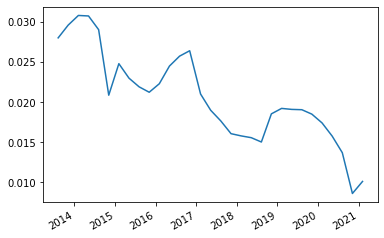

In [115]:
isf_dividends['dividend_yield'][4:].plot()

<AxesSubplot:>

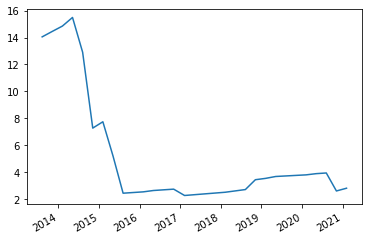

In [116]:
isf_dividends['dividend'].rolling('365d').sum()[4:].plot()

<AxesSubplot:>

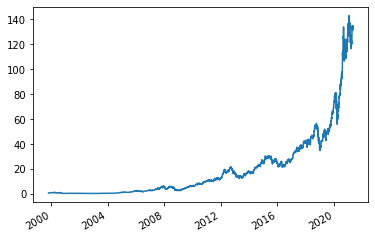

In [117]:
isf.adjusted_close.plot()

In [118]:
# dividends show us quite obvious to detect large dicrepencies between dividend and stock price 
# (assuming dividends are proxy for earnings)

In [119]:
from fbprophet import Prophet

In [120]:
fb_isf = isf[['adjusted_close']].reset_index().rename(columns={'index': 'ds', 'adjusted_close': 'y'})

In [121]:
m = Prophet()
m.fit(fb_isf)

In [122]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5769,2022-04-26
5770,2022-04-27
5771,2022-04-28
5772,2022-04-29
5773,2022-04-30


In [123]:
forecast = m.predict(future)

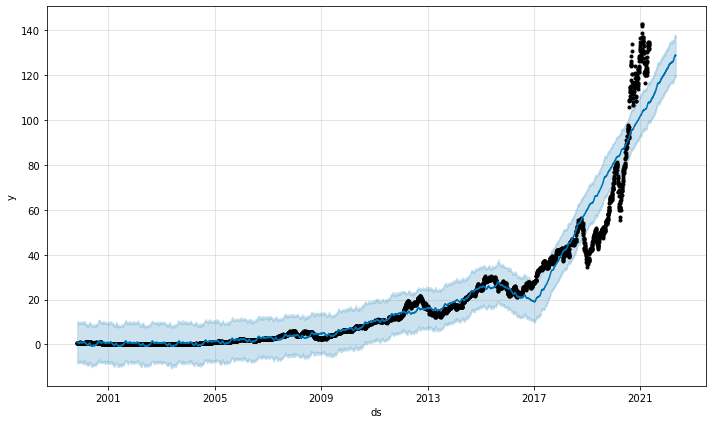

In [124]:
fig1 = m.plot(forecast)

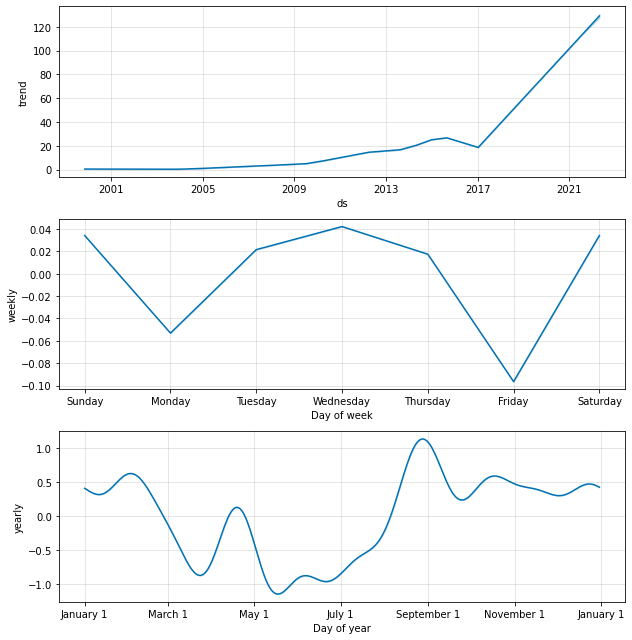

In [125]:
fig2 = m.plot_components(forecast)

KeyError: 'yhat'

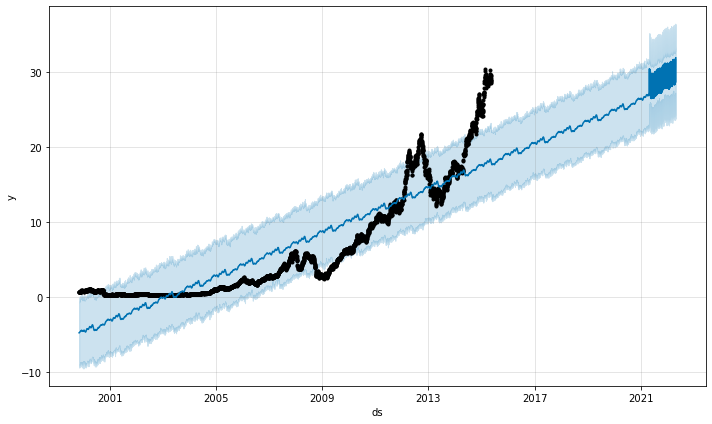

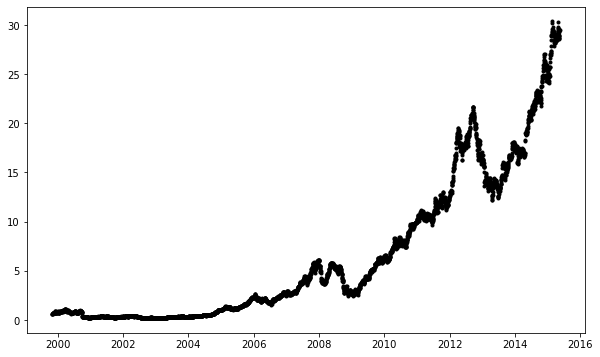

In [126]:
m = Prophet(changepoint_prior_scale=0.5, changepoint_range=0)
forecast = m.fit(fb_isf[1500:]).predict(future)
m.plot(forecast)

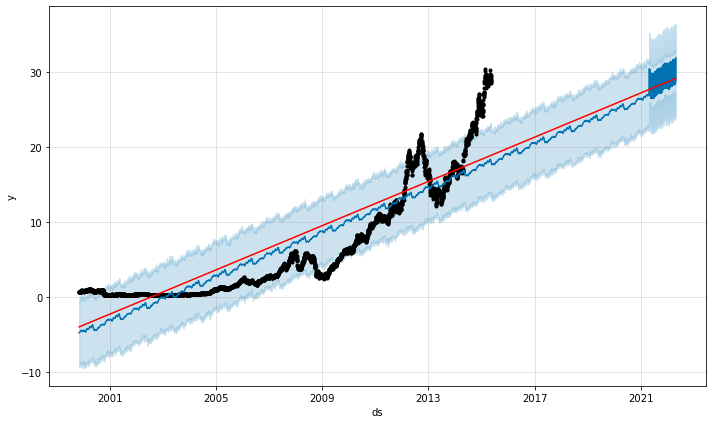

In [127]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [102]:
# seasonality, holidays etc
# removal of outliers: lock down etc?
# non-daily data and gaps in data (e.g. weekends or bank holidays?)
# diagnostics - CV and verifying results
# warm start models with previously fit settings (5x future speed up )